In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cvxpy as cvx
from sklearn.metrics import mean_absolute_error as mae
from utils import plot_decomp
import random

from gfosd import Problem
from gfosd.components import SumAbs, SumSquare, Aggregate, AverageEqual, Periodic

# `l2_l1d1_l2d2`

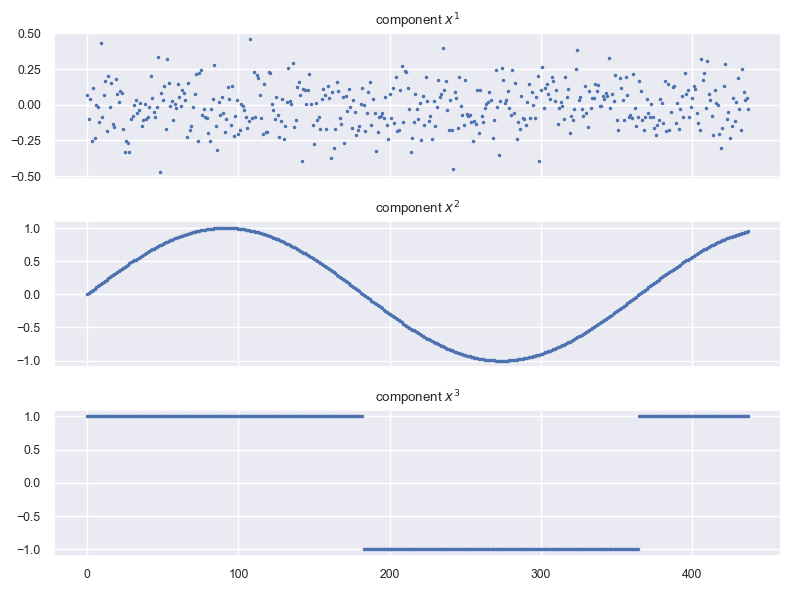

In [2]:
np.random.seed(12) 
random.seed(10)
t = np.arange(365*1.2)

signal2 = np.sin(2 * np.pi * t * 1 / (365.))  
signal3 = signal.square(2 * np.pi * t * 1 / (365.)) 
signal1 = 0.15 * np.random.randn(len(signal2))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

# OSD + MOSEK

In [3]:
def gfosd_mosek(y=y,
              w1=5/len(y),
              w2=100/len(y),
              w3=1/len(y),
              plot=False,
              yearly_periodic=True,
              solver='MOSEK'
             ):

    c1 = SumSquare(weight=w1)
    c2 = SumSquare(weight=w2, diff=2)
    c3 = SumAbs(weight=w3, diff=1) 
    
    if len(y) > 365 and yearly_periodic:
        c2 = Aggregate([c2, Periodic(365), AverageEqual(0, period=365)]) # last one should be above

    classes = [c1, c2]
    classes = [c1, c2, c3]

    problem = Problem(y, classes)
    problem.decompose(solver=solver)

    s_error =  problem.decomposition[0]
    s_seas = problem.decomposition[1]
    s_hat = problem.decomposition[2]

    gfosd_output_dict = {
        "s_seas_mosek": list(s_seas),
        "s_error_mosek": list(s_error),
        "s_hat_mosek": list(s_hat),
        "obj_val_mosek": problem.objective_value
    }
    if plot:
        plot_decomp([s_error, s_seas, s_hat], X_real)
    
    return gfosd_output_dict

# CVXPY + MOSEK

In [4]:
def cvxpy_mosek(y=y,
              w1=5,
              w2=100,
              w3=1,
              plot=False,
              output_osd=None, # for calculating OSD equivalent objective
              yearly_periodic=True
             ):
    
    s_hat = cvx.Variable(len(y))
    s_seas = cvx.Variable(len(y))
    s_error = cvx.Variable(len(y))

    objective = cvx.Minimize(
        w1 * cvx.sum_squares(s_error) + w2 * cvx.sum_squares(cvx.diff(s_seas, k=2)) + w3 * cvx.norm1(cvx.diff(s_hat, k=1))
    )

    # Consistency constraint    
    constraints = [
        y == s_hat + s_seas + s_error ,
        cvx.sum(s_seas[:365]) == 0,
    ]
    if len(y) > 365:
        constraints.append(s_seas[365:] - s_seas[:-365] == 0)
        if yearly_periodic:
            constraints.append(s_hat[365:] - s_hat[:-365] == 0)

    problem = cvx.Problem(objective=objective, constraints=constraints)
    problem.solve(solver="MOSEK")


    cvxpy_output_dict = {
        "s_seas_mosek": list(s_seas.value),
        "s_error_mosek": list(s_error.value),
        "s_hat_mosek": list(s_hat.value),
        "obj_val_mosek": problem.objective.value
    }

    if output_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        s_hat.value = output_osd["s_hat_mosek"]
        s_seas.value = output_osd["s_seas_mosek"]
        s_error.value = output_osd["s_error_mosek"]
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value

    if plot:
        plot_decomp([s_error.value, s_seas.value, s_hat.value], X_real)
    
    return cvxpy_output_dict

# Tests

CVXPY objective       136.34793
OSD objective, scaled 137.08524
s_seas MAE (OSD,CVX)   6.74e-02
s_hat MAE (OSD,CVX)   7.07e-02


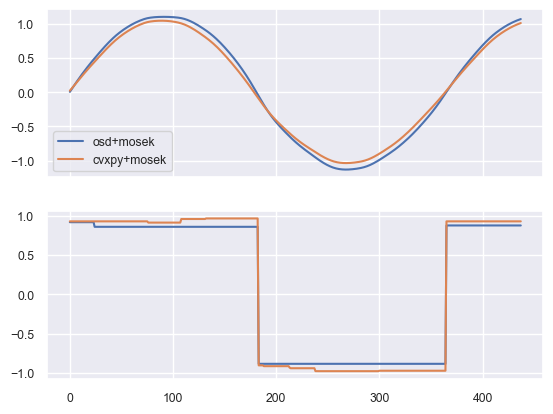

In [12]:
weights = { 'w1' : 10,
            'w2' : 1e5,
            'w3' : 10
          }

osd_output = gfosd_mosek(**weights)
cvxpy_output = cvxpy_mosek(**weights, output_osd=osd_output)

cvxpy_output = cvxpy_mosek(**weights)

print(f's_seas MAE (OSD,CVX)   {mae(osd_output["s_seas_mosek"], cvxpy_output["s_seas_mosek"]):.2e}')
print(f's_hat MAE (OSD,CVX)   {mae(osd_output["s_hat_mosek"], cvxpy_output["s_hat_mosek"]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output["s_seas_mosek"], label="osd+mosek")
ax1.plot(cvxpy_output["s_seas_mosek"], label="cvxpy+mosek")
ax2.plot(osd_output["s_hat_mosek"], label="osd+mosek")
ax2.plot(cvxpy_output["s_hat_mosek"], label="cvxpy+mosek")
ax1.legend();

CVXPY objective       136.34793
OSD objective, scaled 137.16224
s_seas MAE (OSD,CVX)   6.75e-02
s_hat MAE (OSD,CVX)   7.09e-02


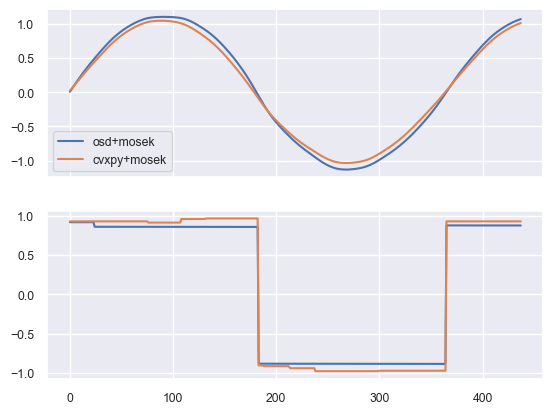

In [13]:
weights = { 'w1' : 10,
            'w2' : 1e5,
            'w3' : 10
          }

osd_output = gfosd_mosek(**weights, solver="QSS")
cvxpy_output = cvxpy_mosek(**weights, output_osd=osd_output)

cvxpy_output = cvxpy_mosek(**weights)

print(f's_seas MAE (OSD,CVX)   {mae(osd_output["s_seas_mosek"], cvxpy_output["s_seas_mosek"]):.2e}')
print(f's_hat MAE (OSD,CVX)   {mae(osd_output["s_hat_mosek"], cvxpy_output["s_hat_mosek"]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output["s_seas_mosek"], label="osd+mosek")
ax1.plot(cvxpy_output["s_seas_mosek"], label="cvxpy+mosek")
ax2.plot(osd_output["s_hat_mosek"], label="osd+mosek")
ax2.plot(cvxpy_output["s_hat_mosek"], label="cvxpy+mosek")
ax1.legend();